# Stepik ML Contest (Conspect)
## Часть 1.
Практическим проектом нашего [курса](https://stepik.org/course/4852/syllabus) будет анализ активности студентов онлайн курса "Введение в анализ данных в R".

Описание данных:
- [events_train.csv](https://stepik.org/media/attachments/course/4852/event_data_train.zip) - данные о действиях, которые совершают студенты со стэпами.
    1. step_id - id стэпа
    2. user_id - анонимизированный id юзера
    3. timestamp - время наступления события в формате unix date
    4. action - событие, возможные значения: 
        - discovered - пользователь перешел на стэп
        - viewed - просмотр шага,
        - started_attempt - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага
        - passed - удачное решение практического шага. 
- [submissions_train.csv](https://stepik.org/media/attachments/course/4852/submissions_data_train.zip) - данные о времени и статусах сабмитов к практическим заданиям.
    1. step_id - id стэпа
    2. timestamp - время отправки решения в формате unix date
    3. submission_status - статус решения
    4. user_id - анонимизированный id юзера



Представим, что мы Дата-Аналитики в Степике и мы хотим предсказать/узнать, почему пользователи не заканчивают до конца курсы, что мы можем сделать, чтобы они заканчивали курсы и т.д.

In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme()
plt.figure(figsize=(15, 15))

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

Выгрузим данные, взглянем на них

In [223]:
events_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip', compression ='zip')
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


Как мы можем заметить, данные выше не подходят для обучения каких-то моделей. Это сырые данные, которые не годятся для обучения и которые еще предстоит предобработать и подготовить для скармливания их модели.

При работе со временем очень часто используют формат timestamp ([Unix time](https://ru.wikipedia.org/wiki/Unix-%D0%B2%D1%80%D0%B5%D0%BC%D1%8F)). Привыкаем =)

В самую первую очередь, даже перед предобработкой и feature-инжиниринга, мы должны убедится в том, что данные, которые к нам пришли правильные, валидные, содержат в себе то, что должны и не содержат то, что не должны.

In [224]:
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [225]:
events_data.dtypes

step_id       int64
timestamp     int64
action       object
user_id       int64
dtype: object

Timestamp хоть и удобен в использовании в программировании, но он совсем неудобен для аналитики, группировки по дням, месяцам, исследования наших данных. Поэтому переведем наши данные в более наглядный вид.

In [226]:
events_data["date"] = pd.to_datetime(events_data.timestamp, unit="s")
events_data.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [227]:
events_data.date.min()

Timestamp('2015-06-15 04:00:48')

In [228]:
events_data.date.max()

Timestamp('2018-05-19 23:33:31')

Убеждаемся, что проблем со временем у нас нет. Данные, которые у нас есть содержат в себе информацию за 3 года и даты, которые здесь указаны, адекватны.

Создадим еще одну колонку для сохранения дня, в котором произошло то или иное событие.

In [229]:
events_data["day"] = events_data.date.dt.date
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


Теперь можем попробовать визуализировать эти данные, изучить, как изменялась динамика действий на курсе, и в целом увидеть, какая история таится за этим полотном данных.

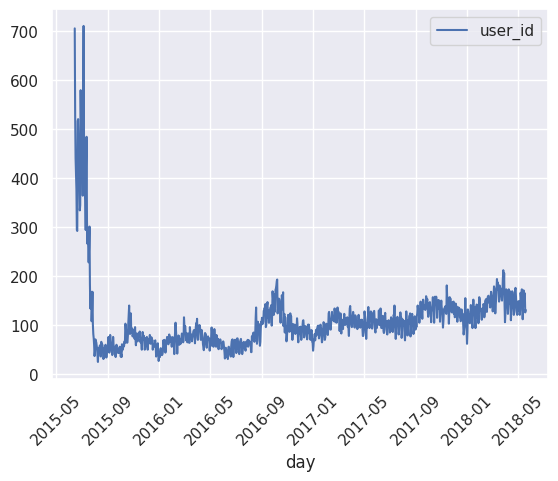

In [230]:
events_data\
    .groupby("day")\
    .agg({"user_id": "nunique"})\
    .plot().tick_params(axis='x', rotation=45)

Распределение пользователей по дням мы изучили, теперь рассмотрим распределение пользователей по количеству баллов, которые они набрали за курс.

In [231]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


Сначала рассмотрим НЕПРАВИЛЬНЫЙ способ посчитать количество набранных баллов у пользователей.

Только сперва взглянем на параметры исходного датасета.

In [232]:
events_data.shape

(3480703, 6)

In [233]:
events_data.user_id.nunique()

19234

In [234]:
events_data[events_data.action == "passed"]\
    .groupby("user_id", as_index=False)\
    .agg({"step_id": 'count'})\
    .rename(columns={"step_id": "passed_steps"})\
    .head()

,user_id,passed_steps
0,2,9
1,3,87
2,5,11
3,7,1
4,8,84


<Axes: >

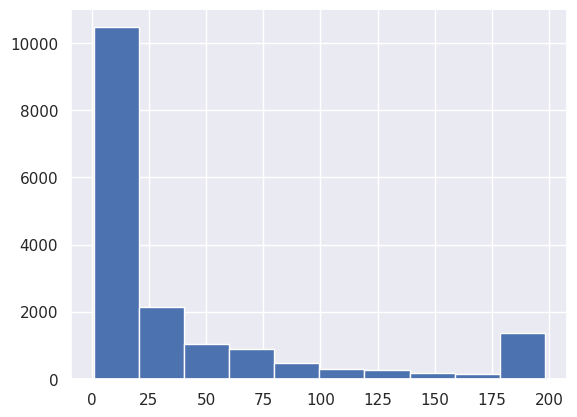

In [235]:
events_data[events_data.action == "passed"]\
    .groupby("user_id", as_index=False)\
    .agg({"step_id": 'count'})\
    .rename(columns={"step_id": "passed_steps"})\
    .passed_steps.hist()

Проблема такого подхода состоит в том, что пользователи, которые прошли 0 степов даже не попали в выборку, т.к. мы отфильтровали только те записи, которые содержат в себе пройденные степы, но пользователь мог и вовсе не пройти ни единого степа.

**НУЖНО СЛЕДИТЬ ЗА ВСЕМ ПРОИСХОДЯЩЕМ НА ЭТАПЕ ПРЕДОБРАБОТКИ, ЧТОБЫ НЕ ПОТЕРЯТЬ ДАННЫЕ.**

Постоянно себя валидируем. Проверяем, что число уников не изменилось. В данном случае мы должны проверить, что число уникальных пользователей не изменилось.

In [236]:
events_data[events_data.action == "passed"]\
    .groupby("user_id", as_index=False)\
    .agg({"step_id": 'count'})\
    .rename(columns={"step_id": "passed_steps"})\
    .user_id.nunique()

17262

Как мы можем заметить, оно изменилось. Уменьшилось на ~2 тысячи (когда выше мы насчитали 19234 уникальных пользователей). Т.е. мы просто взяли и отбросили 2 тысячи пользователей, чего делать нельзя, т.к. мы можем потерять очень много важной, повторюсь, ИСКЛЮЧИТЕЛЬНО ВАЖНОЙ информации. Может быть и так, что людей, которых мы отбросили, даже больше чем людей, которых мы оставили. 

За обработкой данных нужно следить крайне внимательно.

Теперь рассмотрим ПРАВИЛЬНЫЙ подход к подсчету пользователей и количества степов, которые они прошли.

Познакомимся с [pivot_table](https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html).

In [237]:
events_data.pivot_table(
    index="user_id",    # Строки новой таблицы
    columns="action",   # Колонки новой таблицы
    values="step_id",   # Переменная, со значениями которой мы будем делать аггрегацию
    aggfunc="count",    # Агрегационная функция
    fill_value=0        # Заполним NaN значения нулями
).head()

action,discovered,passed,started_attempt,viewed
user_id,,,,
1,1,0,0,1
2,9,9,2,10
3,91,87,30,192
5,11,11,4,12
7,1,1,0,1


Индексы достаточно сумбурно расположены, с ними неудобно работать, поэтому применим [reset_index](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html?highlight=reset_index#pandas.DataFrame.reset_index).

In [238]:
events_data.pivot_table(
    index="user_id",    # Строки новой таблицы
    columns="action",   # Колонки новой таблицы
    values="step_id",   # Переменная, со значениями которой мы будем делать аггрегацию
    aggfunc="count",    # Агрегационная функция
    fill_value=0        # Заполним NaN значения нулями
).reset_index().head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


Взглянем на более честное распределение уников:

<Axes: >

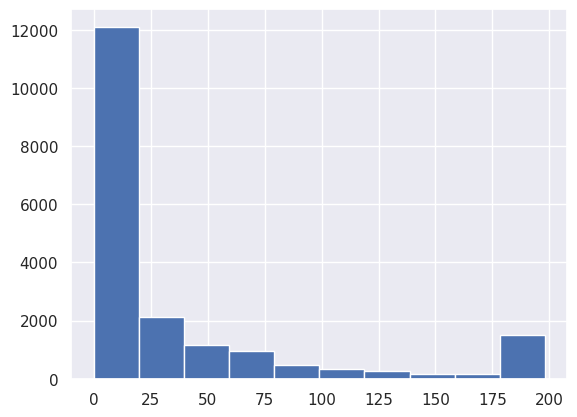

In [239]:
events_data.pivot_table(
    index="user_id",    # Строки новой таблицы
    columns="action",   # Колонки новой таблицы
    values="step_id",   # Переменная, со значениями которой мы будем делать аггрегацию
    aggfunc="count",    # Агрегационная функция
    fill_value=0        # Заполним NaN значения нулями
).reset_index().discovered.hist()

## ЧАСТЬ 2.

In [240]:
submissions_data = pd.read_csv('submissions_data_train.zip',compression ='zip')
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


Предобработаем данные для сабмитов:

In [241]:
submissions_data["date"] = pd.to_datetime(submissions_data.timestamp, unit="s")
submissions_data["day"] = submissions_data.date.dt.date
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [242]:
users_scores = submissions_data.pivot_table(
    values="step_id",
    index="user_id",
    columns="submission_status",
    aggfunc="count",
    fill_value=0
).reset_index()

users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


Необходимо решить следующий вопрос - как долго пользователь не должен проявлять активность, чтобы мы считали его покинувшим курс?

Возьмем наш датасет events_data и посмотрим, как распределены перерывы между днями активностей у пользователей.

In [243]:
# Посмотрим, в какие таймстемпы активничал каждый из пользователей
events_data[["user_id", "day", "timestamp"]]\
    .drop_duplicates(subset=["user_id", "day"])\
    .groupby("user_id")["timestamp"]\
    .apply(list).head()

user_id
1                                         [1472827464]
2                             [1514383364, 1519226966]
3    [1434358476, 1441257725, 1441440209, 144153391...
5                             [1466156809, 1499859621]
7                                         [1521634660]
Name: timestamp, dtype: object

In [244]:
# А теперь посчитаем разницу между этими попытками
events_data[["user_id", "day", "timestamp"]]\
    .drop_duplicates(subset=["user_id", "day"])\
    .groupby("user_id")["timestamp"]\
    .apply(list)\
    .apply(np.diff).head()

user_id
1                                                  []
2                                           [4843602]
3    [6899249, 182484, 93710, 2768870, 171400, 78712]
5                                          [33702812]
7                                                  []
Name: timestamp, dtype: object

In [245]:
gap_data = events_data[["user_id", "day", "timestamp"]]\
    .drop_duplicates(subset=["user_id", "day"])\
    .groupby("user_id")["timestamp"]\
    .apply(list)\
    .apply(np.diff)\
    .values

gap_data

array([array([], dtype=int64), array([4843602]),
       array([6899249,  182484,   93710, 2768870,  171400,   78712]), ...,
       array([   86128,   136759,    94899,  1422583, 14347289,   505061,
                 98252,    57019])                                       ,
       array([1567990]), array([], dtype=int64)], dtype=object)

In [246]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))
gap_data = gap_data / (24 * 3600)

<Axes: >

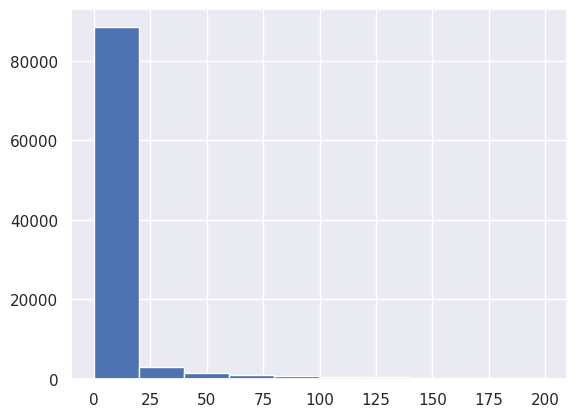

In [247]:
gap_data[gap_data < 200].hist()

In [248]:
print(f'90% квантиль: {gap_data.quantile(0.90)}')
print(f'95% квантиль: {gap_data.quantile(0.95)}')


90% квантиль: 18.325995370370403
95% квантиль: 59.760440972222156


Возьмем нечто среднее и скажем, что если пользователь не был на курсе 30 дней, то он покинул курс.

In [249]:
drop_out_threshold = 30 * 24 * 3600

Выберем точку, относительно которой мы считаем, что если до этого дня пользователь не заходил 30 дней, то он отвалившийся (при этом он не прошел курс)

In [250]:
now = events_data.timestamp.max()

Получим данные о последнем посещении курса

In [251]:
users_data = events_data.groupby("user_id", as_index=False)\
    .agg({"timestamp": "max"})\
    .rename(columns={"timestamp": "last_timestamp"})

users_data.head()

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


In [252]:
users_data["is_gone_user"] = (now - users_data.last_timestamp) > drop_out_threshold
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


Добавим данные о количестве правильных и неправильных сабмитов.

In [253]:
# Левый мерж, т.к. users_data хранит в себе всех пользователей
users_data = users_data.merge(users_scores, how="left", on="user_id")

# Убедимся, что мы не потеряли данные
print(users_data.shape) 

# Заполним нулевые значения
users_data = users_data.fillna(0)

users_data.head()

(19234, 5)


,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0


Достанем данные из первой части про информацию о совершенных действиях пользователя

In [254]:
users_events = events_data.pivot_table(
    index="user_id",
    columns="action",
    values="step_id",
    aggfunc="count",
    fill_value=0
).reset_index()

users_events.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [255]:
users_data = users_data.merge(users_events, how="left", on="user_id")
users_data

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1
...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9
19230,26793,1510225034,True,0.0,0.0,1,0,1,1
19231,26794,1512035039,True,33.0,9.0,69,69,34,180
19232,26797,1509995096,True,2.0,0.0,10,10,2,13


Теперь добавим еще одну статистику, а именно - сколько уникальных дней пользователь активничал на сайте.

In [256]:
users_days = events_data\
    .groupby("user_id")\
    .day.nunique()\
    .to_frame()\
    .reset_index()

users_days

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1
...,...,...
19229,26790,4
19230,26793,1
19231,26794,9
19232,26797,2


In [257]:
users_data = users_data.merge(users_days, how="left", on="user_id")
users_data

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2


Введем последнию колонку, которая несет в себе информацию, закончил ли пользователь курс.

In [258]:
users_data["passed_course"] = users_data.passed > 170
users_data

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False
...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4,False
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1,False
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9,False
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2,False


Посчитаем, как много пользователей из нашего датасета окончили курс.

In [259]:
# В абсолютных числах
print(users_data['passed_course'].value_counts(), "\n")

# В процентах
print(users_data['passed_course'].value_counts(normalize=True))

False    17809
True      1425
Name: passed_course, dtype: int64 

False    0.925912
True     0.074088
Name: passed_course, dtype: float64


Хоть мы и сделали столь важный этап предобработки данных, мы все еще не можем обучить нашу модель и ответить на поставленный вопрос. 

Мы должны быть способны предстказать отвал пользователей как можно раньше, например в первые семь дней.

## Часть 3.
Наша цель: как можно раньше предсказать, что пользователь уйдет с курса "Анализ данных в R".

In [260]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


Взглянем на медианное значение проведенных на курсе уникальных дней, а также посмотрем, как распределены пользователи по количеству дней на курсе.

20.0


<Axes: >

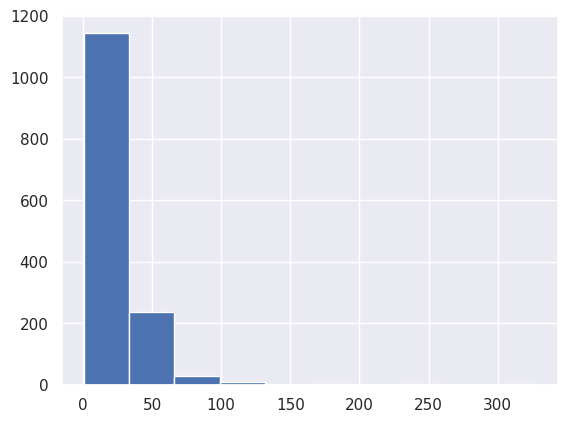

In [261]:
print(users_data[users_data.passed_course].day.median())
users_data[users_data.passed_course].day.hist()

Сейчас наша задача - это отобрать данные для обучения, а именно: достать события, которые происходили с пользователем в течении первых трех дней.

Три дня отсчитываются для каждого пользователя индивидуально, начиная с первого дня его активности.

In [262]:
user_min_time = events_data\
    .groupby("user_id", as_index=False)\
    .agg({"timestamp": "min"})\
    .rename(columns={"timestamp": "min_timestamp"})

user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [263]:
users_data = users_data.merge(user_min_time, how="left", on="user_id")
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


In [264]:
learning_time_threshold = 3 * 24 * 3600

Теперь мы сообразим интересную фильтрацию.
<br>Из events_data мы должны будем отобрать только те данные, для которых записи пользователя попадают под окно первых 3 дней его активности.

Это достаточно нетривиальная фильтрация, и есть несколько вариантов ее оформить.

Начнем с САМОГО НЕПРАВИЛЬНОГО способа!

In [265]:
# events_data_train = pd.DataFrame()

# for user_id in users_data.user_id:
#     min_user_time = users_data[users_data.user_id == user_id]["min_timestamp"].item()
#     time_threshold = min_user_time + learning_time_threshold

#     user_events_data = events_data[
#         (events_data.user_id == user_id) &
#         (events_data.timestamp < time_threshold)
#     ]

#     events_data_train = events_data_train.append(user_events_data)

# ОПЕРАЦИЯ ОЧЕНЬ ДОЛГАЯ И НЕЭФФЕКТИВНАЯ. НЕ PANDAS-WAY

Операция, описанная выше, очень долгая и не подходит под оптимальное решение задачи. Не пандас-вей.

Разберем ПРАВИЛЬНЫЙ способ решить поставленную задачу.

In [266]:
events_data["user_time"] = events_data.user_id.map(str) + "_" + events_data.timestamp.map(str)
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895


In [267]:
user_learning_time_threshold = user_min_time.user_id.map(str) + "_" + \
    (user_min_time.min_timestamp + learning_time_threshold).map(str)

user_learning_time_threshold.head()

0    1_1473086664
1    2_1514642564
2    3_1434617676
3    5_1466416009
4    7_1521893860
dtype: object

In [268]:
user_min_time["user_learning_time_threshold"] = user_learning_time_threshold
user_min_time.head()

,user_id,min_timestamp,user_learning_time_threshold
0,1,1472827464,1_1473086664
1,2,1514383364,2_1514642564
2,3,1434358476,3_1434617676
3,5,1466156809,5_1466416009
4,7,1521634660,7_1521893860


In [269]:
events_data = events_data.merge(user_min_time[["user_id", "user_learning_time_threshold"]], how="left", on="user_id")
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [270]:
events_data.shape

(3480703, 8)

Теперь мы можем просто сравнить данные из колонок user_time и user_learning_time_threshold и отфильтровать только те наблюдения, которые актуальны за первые 3 дня активности.

In [271]:
events_data_train = events_data.query("user_time <= user_learning_time_threshold")
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [272]:
events_data_train.shape

(1014985, 8)

<hr>

### Минутка практики:
В процессе решения одной аналитической задачи очень часто замечаешь и другие задачи, связанные с исследуемым вопросом. В свое время, работая над предсказанием оттока студентов со stepik, я многое изменил в структуре своих курсов. 

Тогда я нашел довольно интересную закономерность прохождения онлайн курсов. Слушатели онлайн курсов очень негативно реагируют на невозможность решить задачу, иными словами, если студент застрял на определенном шаге, то он, с высокой вероятность, вообще бросит курс, чем просто пропустит этот шаг и продолжит обучение. 

Давайте найдем такой стэп, используя данные о сабмитах. Для каждого пользователя найдите такой шаг, который он не смог решить, и после этого не пытался решать другие шаги. Затем найдите id шага,  который стал финальной точкой практического обучения на курсе для максимального числа пользователей. 

То есть мы исследуем следующий сценарий: человек решает стэп, не может получить правильный ответ и больше не возвращается к практическим задачам. Что это за шаг такой, который отпугнул максимальное число пользователей?

In [273]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [274]:
submissions_data\
    .query("submission_status == 'wrong'")\
    .groupby("step_id", as_index=False)\
    .agg({"user_id": "count"})\
    .sort_values(ascending=False, by="user_id")

,step_id,user_id
4,31978,16084
11,32031,13373
19,32202,13002
44,33481,10300
12,32075,10003
...,...,...
45,33482,707
59,33681,703
36,33362,673
16,32175,342


### Результат:<br>
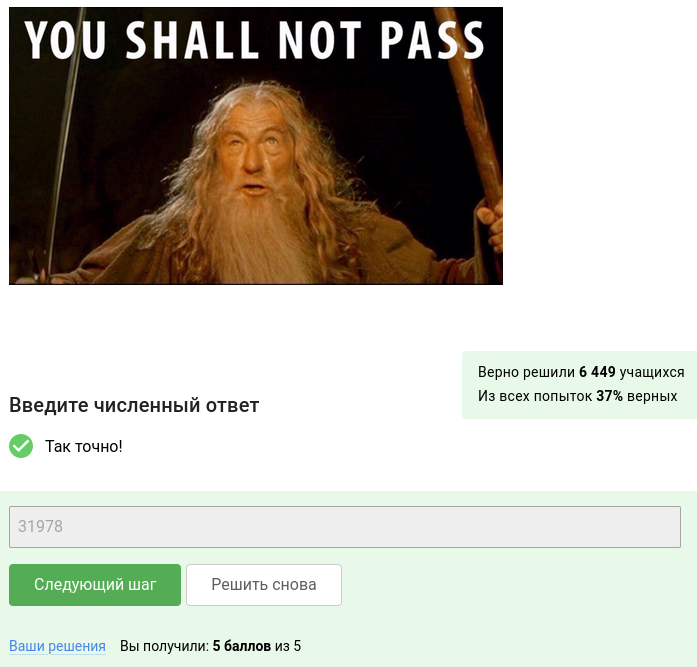
<hr>

### Продолжение конспекта третей части.

Проверим, сколько максимально дней для записей каждого пользователя мы можем иметь в наших тренировочных данных

In [275]:
events_data_train\
    .groupby("user_id")\
    .day.nunique().max()

4

Как и должно быть, мы можем иметь максимум 4 уникальных дня для каждого пользователя (т.к. трое суток могут захватить 4 уникальных дня)

Чтобы не терять время, обработаем и сабмишны

In [276]:
submissions_data['users_time'] = submissions_data.user_id.map(str) + '_' + submissions_data.timestamp.map(str)
submissions_data = submissions_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
submissions_data_train = submissions_data[submissions_data.users_time <= submissions_data.user_learning_time_threshold]
submissions_data_train.groupby('user_id').day.nunique().max()

4

### Перейдем к формированию данных для обучения

In [277]:
X = submissions_data_train.groupby("user_id").day.nunique().to_frame().reset_index()
X.head()

,user_id,day
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3


In [278]:
steps_tried = submissions_data_train.groupby("user_id")\
    .step_id.nunique().to_frame().reset_index()\
    .rename(columns={"step_id": "steps_tried"})

steps_tried.head()

,user_id,steps_tried
0,2,2
1,3,4
2,8,11
3,14,1
4,16,23


In [279]:
X = X.merge(steps_tried, how="left", on="user_id")
X.head()

,user_id,day,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23


In [280]:
X = X.rename(columns={"day": "days"})
X.head()

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23


In [281]:
submissions_data_train.head()

,step_id,timestamp,submission_status,user_id,date,day,users_time,user_learning_time_threshold
0,31971.0,1.434349e+09,correct,15853,2015-06-15 06:21:15,2015-06-15,15853_1434349275,15853_1434605177
1,31972.0,1.434348e+09,correct,15853,2015-06-15 06:05:00,2015-06-15,15853_1434348300,15853_1434605177
4,31976.0,1.434348e+09,wrong,15853,2015-06-15 06:02:03,2015-06-15,15853_1434348123,15853_1434605177
5,31976.0,1.434348e+09,correct,15853,2015-06-15 06:03:08,2015-06-15,15853_1434348188,15853_1434605177
7,31977.0,1.434347e+09,correct,15853,2015-06-15 05:49:31,2015-06-15,15853_1434347371,15853_1434605177


In [282]:
X = X.merge(submissions_data_train.pivot_table(
    index="user_id",
    columns="submission_status",
    values="step_id",
    aggfunc="count",
    fill_value=0
).reset_index())
X

,user_id,days,steps_tried,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,3,23,23,27
...,...,...,...,...,...
8908,26787,1,3,3,0
8909,26790,1,1,1,0
8910,26794,3,27,31,9
8911,26797,1,2,2,0


In [283]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)
X

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.000000
1,3,1,4,4,4,0.500000
2,8,1,11,9,21,0.300000
3,14,1,1,0,1,0.000000
4,16,3,23,23,27,0.460000
...,...,...,...,...,...,...
8908,26787,1,3,3,0,1.000000
8909,26790,1,1,1,0,1.000000
8910,26794,3,27,31,9,0.775000
8911,26797,1,2,2,0,1.000000


In [284]:
X = X.merge(events_data_train.pivot_table(
    index="user_id",
    columns="action",
    values="step_id",
    aggfunc="count",
    fill_value=0
).reset_index()[["user_id", "viewed"]], how="outer")

X

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132
...,...,...,...,...,...,...,...
19229,26774,NaN,NaN,NaN,NaN,NaN,1
19230,26781,NaN,NaN,NaN,NaN,NaN,6
19231,26788,NaN,NaN,NaN,NaN,NaN,1
19232,26789,NaN,NaN,NaN,NaN,NaN,2


In [285]:
X = X.fillna(0)

In [286]:
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone_user']], on="user_id", how="outer" )
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


In [287]:
X = X[X.is_gone_user | X.passed_course]
X

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True
...,...,...,...,...,...,...,...,...,...
19229,26774,0.0,0.0,0.0,0.0,0.00,1,False,True
19230,26781,0.0,0.0,0.0,0.0,0.00,6,True,True
19231,26788,0.0,0.0,0.0,0.0,0.00,1,False,True
19232,26789,0.0,0.0,0.0,0.0,0.00,2,False,True


In [288]:
y = X.passed_course.map(int)
X = X.drop(["passed_course", "is_gone_user"], axis=1)

В датафрейме X все еще хранятся id пользователей. Давайте сделаем эти id индексами для датафрейма.

In [289]:
X = X.set_index("user_id")
X

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132
...,...,...,...,...,...,...
26774,0.0,0.0,0.0,0.0,0.00,1
26781,0.0,0.0,0.0,0.0,0.00,6
26788,0.0,0.0,0.0,0.0,0.00,1
